u0_train.shape =  (5000, 16384)
type of u0_train =  <class 'numpy.ndarray'>
u0_testing.shape =  (1000, 16384)
s_train.shape =  (5000, 16384)
s_testing.shape =  (1000, 16384)
xy_train_testing.shape (16384, 2)
Compiling model...
'compile' took 0.000164 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.90e-02]    [1.52e-02]    [1.04e+00]    
Epoch 1: train loss improved from inf to 1.90e-02, saving model to /scratch/bbpq/qibang/repository/Adap_data_driven_possion/saved_model/FenicsData/model.ckpt-1.pt ...

1000      [3.55e-03]    [3.39e-03]    [5.69e-01]    
Epoch 1000: train loss improved from 1.90e-02 to 3.55e-03, saving model to /scratch/bbpq/qibang/repository/Adap_data_driven_possion/saved_model/FenicsData/model.ckpt-1000.pt ...

2000      [2.04e-03]    [2.03e-03]    [4.62e-01]    
Epoch 2000: train loss improved from 3.55e-03 to 2.04e-03, saving model to /scratch/bbpq/qibang/repository/Adap_data_driven_possion/saved_model/FenicsData/model.ckpt-20

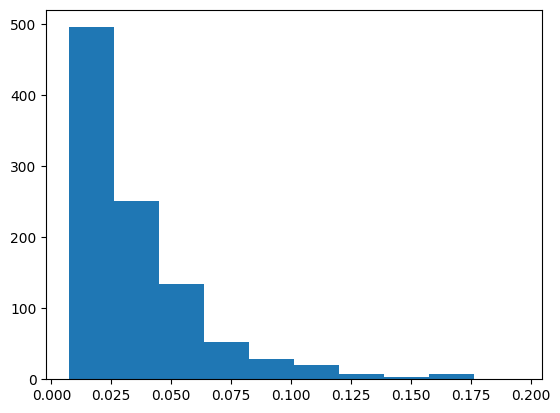

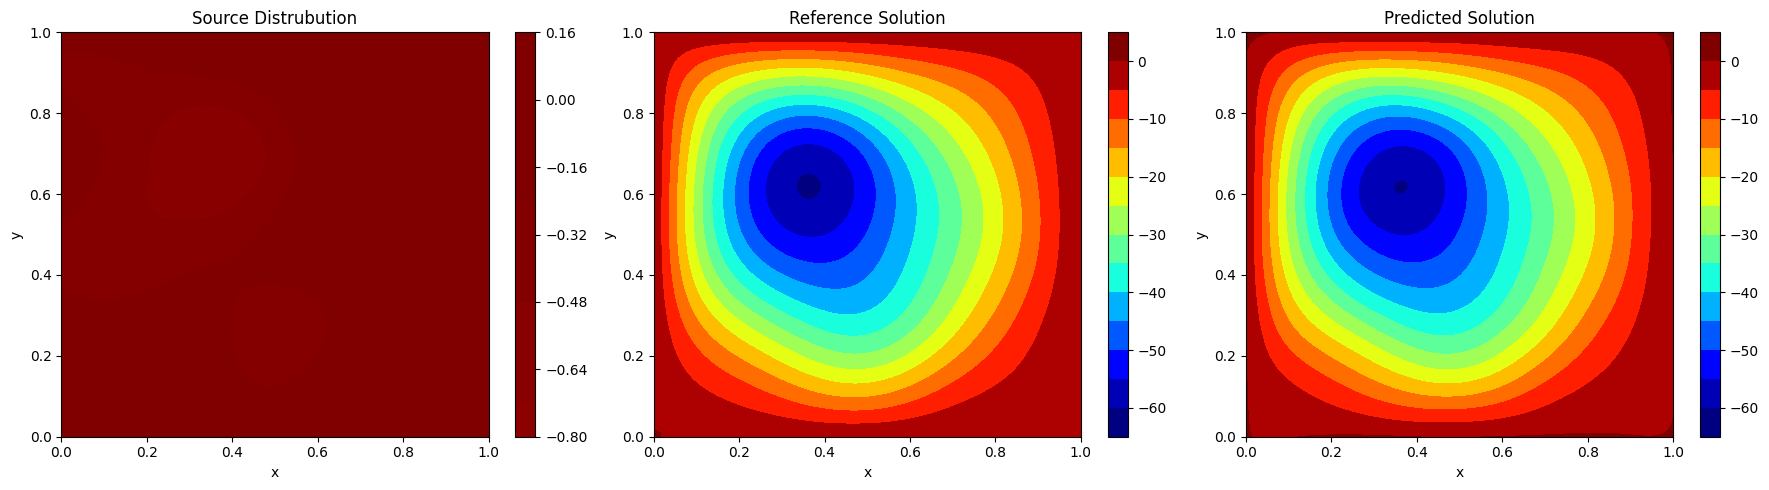

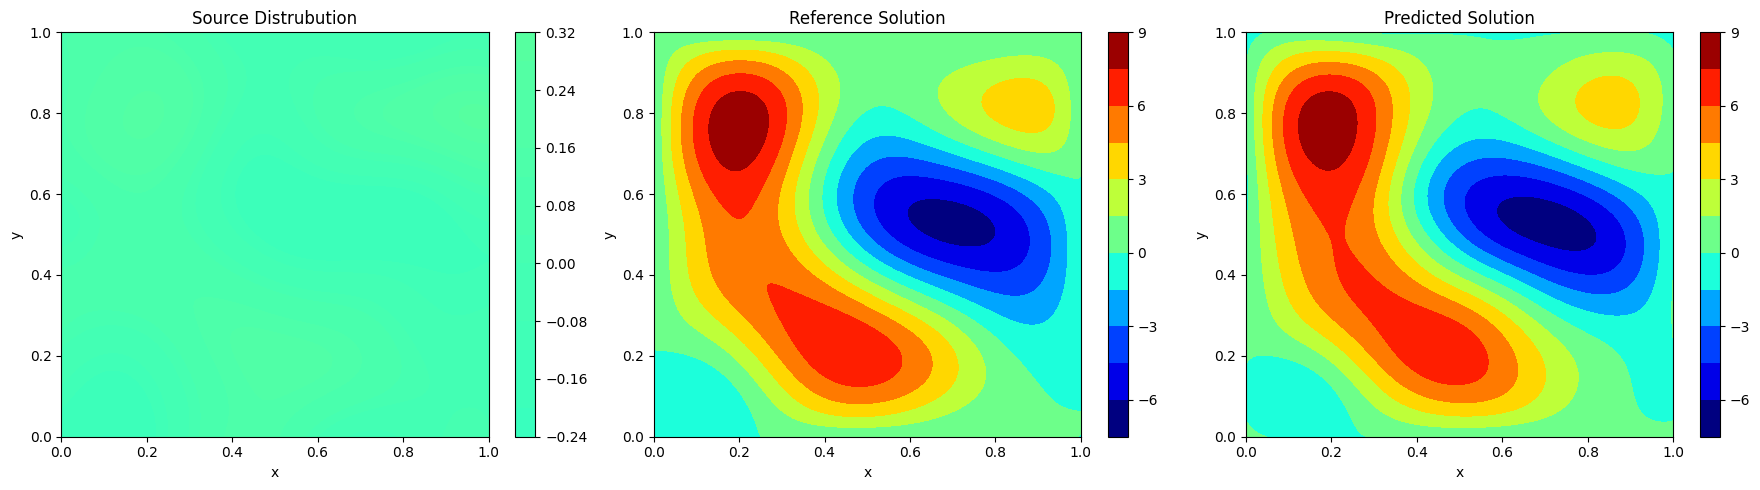

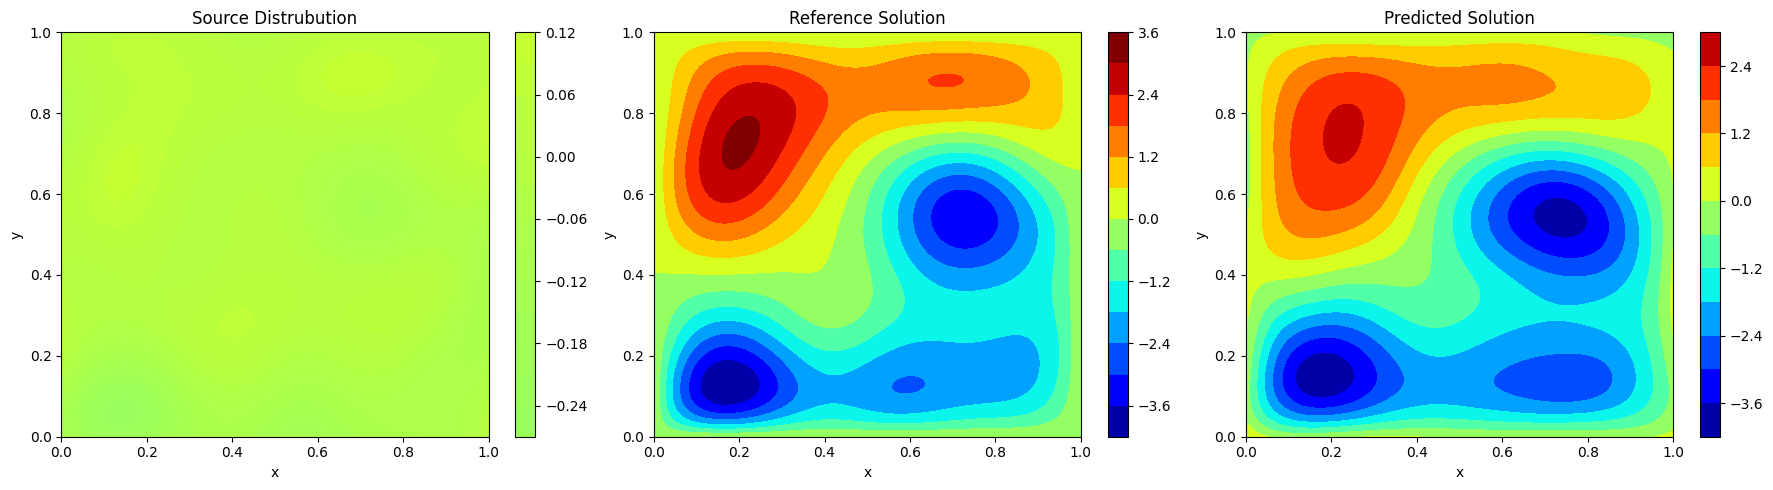

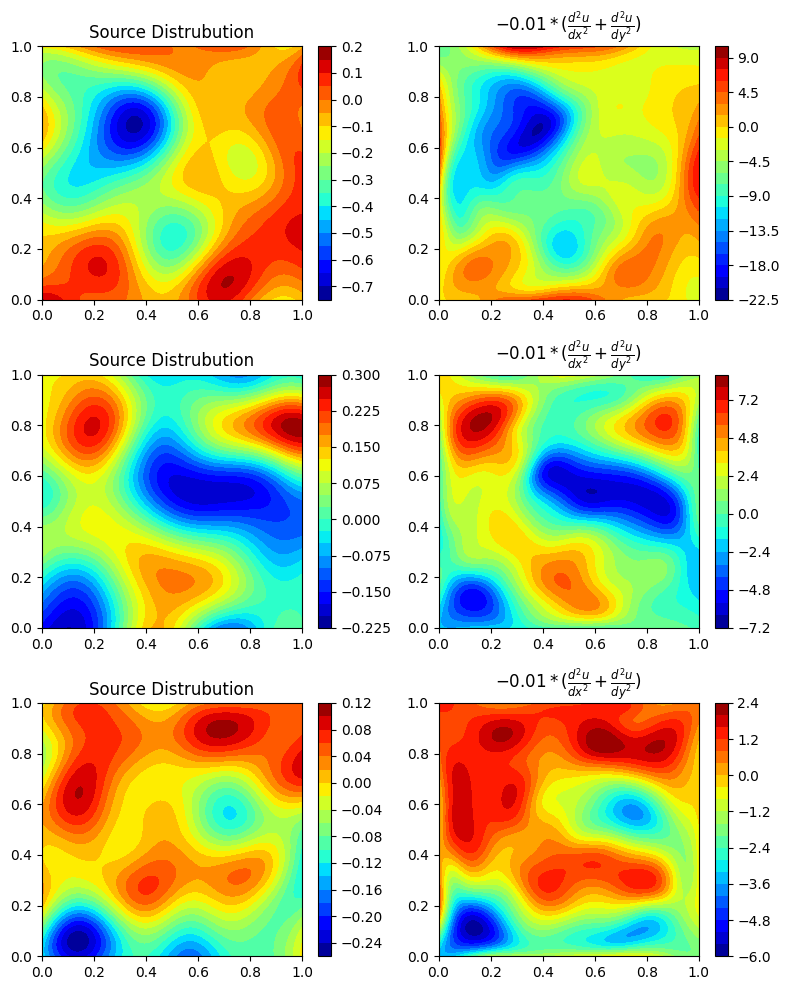

In [35]:
%run poisson_ddm-deeponet.py

In [32]:
def LaplaceOperator2D(x, y,aux=None):
    dy_dx = torch.autograd.grad(
        outputs=y, inputs=x, grad_outputs=torch.ones_like(y), create_graph=True
    )[0]
    dydx, dydy = dy_dx[:, 0:1], dy_dx[:, 1:2]
    dydx2 = torch.autograd.grad(
        dydx,
        x,
        grad_outputs=torch.ones_like(dydx),
        create_graph=True,
    )[0][:, 0:1]
    dydy2 = torch.autograd.grad(
        dydy, x, grad_outputs=torch.ones_like(dydy), create_graph=True
    )[0][:, 1:2]

    return  (dydx2 + dydy2) 

# def LaplaceOperator2D(x, y,aux=None):
#     dydx2 = dde.grad.hessian(y, x, i=0, j=0)
#     dydy2 = dde.grad.hessian(y, x, i=1, j=1)
#     return dydx2 + dydy2


laplace_op = DeepONet.EvaluateDeepONetPDEs(model.net, LaplaceOperator2D)

In [36]:
x_plot=x_test
u0_plot_raw=u0_testing_raw

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_branch, input_trunk = x_plot[0], x_plot[1]
input_branch = torch.tensor(input_branch).to(device)
input_trunk = torch.tensor(input_trunk,requires_grad=True).to(device)

laplace_op_val = laplace_op((input_branch[min_median_max_index], input_trunk))
laplace_op_val = -0.01*scaler_solution* laplace_op_val.detach().cpu().numpy()

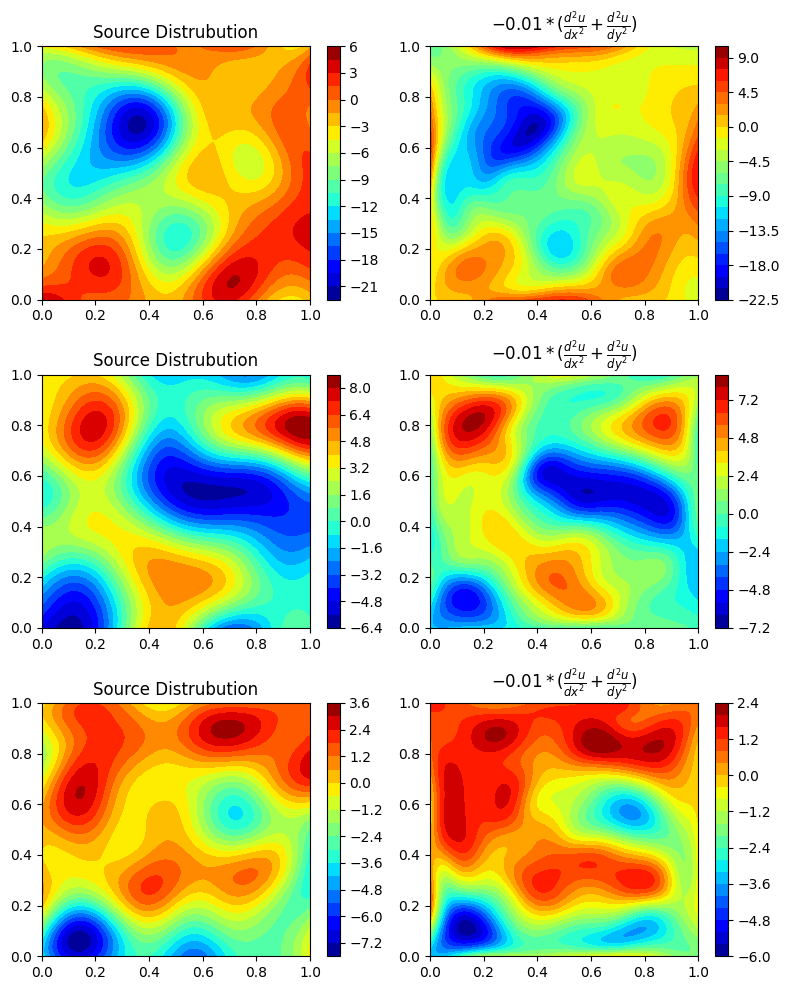

In [37]:
nr, nc = 3, 2
i = 0
fig = plt.figure(figsize=(8, 10))

for i, index in enumerate(min_median_max_index):

    vmin = np.min(u0_plot_raw[index])
    vmax = np.max(u0_plot_raw[index])

    ax = plt.subplot(nr, nc, nc * i + 1)
    # py.figure(figsize = (14,7))
    c1 = ax.contourf(
        x_grid, y_grid, u0_plot_raw[index].reshape(Ny, Nx), 20, cmap="jet"
    )
    ax.set_title(r"Source Distrubution")
    cbar = fig.colorbar(c1, ax=ax)
    plt.tight_layout()
    ax = plt.subplot(nr, nc, nc * i + 2)
    # py.figure(figsize = (14,7))
    c2 = ax.contourf(x_grid, y_grid, laplace_op_val[i].reshape(Ny, Nx), 20, cmap="jet")
    ax.set_title(r"$-0.01*(\frac{d^2u}{dx^2}+\frac{d^2u}{dy^2})$")
    cbar = fig.colorbar(c2, ax=ax)
    plt.tight_layout()

